# **Convolutional Neural Network (CNN)**

### **1. Imports**

In [3]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.auto import tqdm

# checking verions
import sys
print(sys.version) # python
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.2.1+cu121
0.17.1+cu121


### **2. Manual Seed**


In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### **3. DataSets(`FashionMNIST`)**

In [5]:
# FashionMNIST
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12096542.44it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204346.73it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3774235.78it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6217183.12it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### **4. Checking `Shape`/`Size`**





In [6]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [7]:
# Access the first element of train_data
train_data[0]

# Unpack the first element of train_data into `image` and `label` variables
image, label = train_data[0]

# Print the shape of the image tensor
print(image.shape)

# NOTE: It does not remove the color channel
# Removes any single-dimensional entries from the shape of the image tensor
print(image.squeeze().shape)

# Adding a new dimension at dim=0 (batch dimension)
print(image.unsqueeze(dim=0).shape)

# Print the label associated with the image
print(label)

torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 28, 28])
9


In [8]:
class_names = train_data.classes
print(class_names)

class_to_idx = train_data.class_to_idx
print(class_to_idx)

print(train_data.targets)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
tensor([9, 0, 0,  ..., 3, 0, 5])


### **5. Visualizing the data Sample**

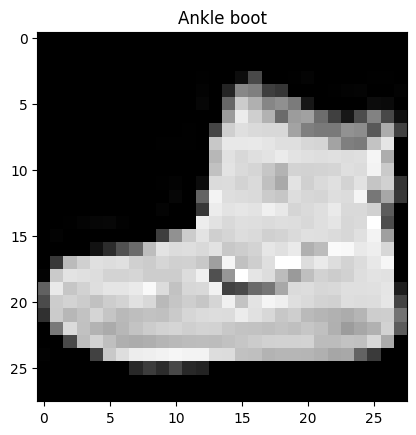

In [9]:
# Ploting the single sample
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.show()

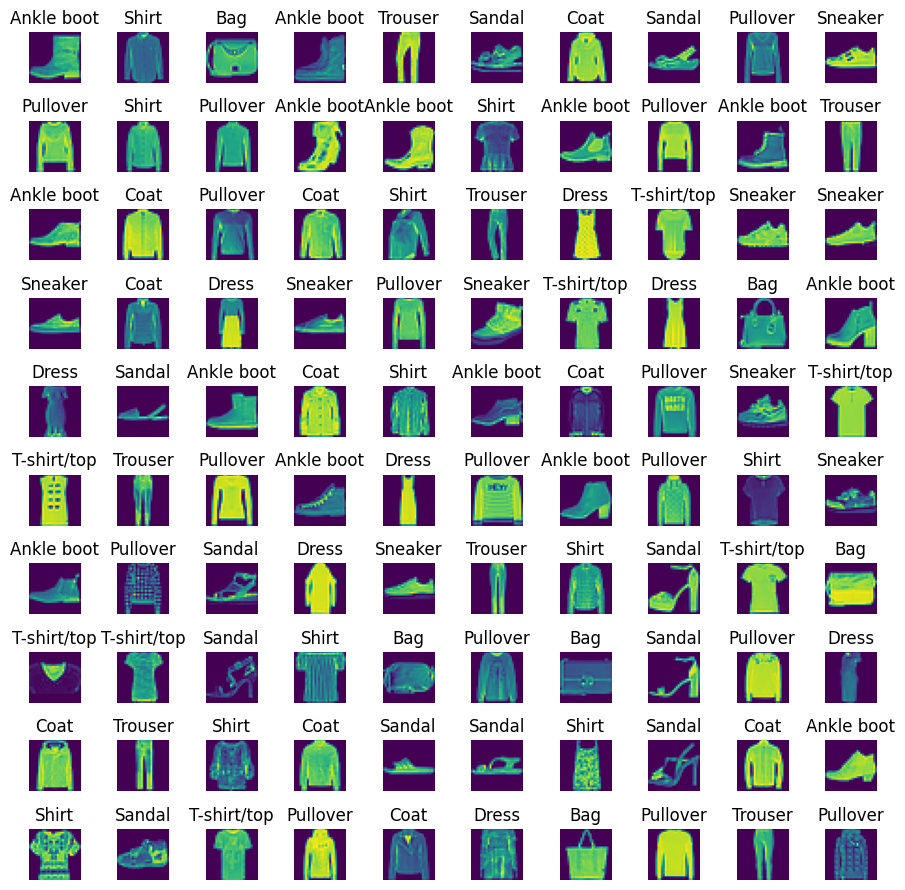

In [10]:
# Plotting the grid of samples
fig = plt.figure(figsize=(9, 9))

rows, cols = 10, 10
# Loop for generating and plotting 16 random samples
for i in range(1, (rows*cols+1)):        # Range adjusted to generate 16 samples (4x4 grid)
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    ax = fig.add_subplot(rows, cols, i)  # Subplot index starts from 1
    ax.imshow(image.squeeze())
    ax.set_title(class_names[label])
    ax.axis('off')                       # Turning off axis labels
plt.tight_layout()                       # Adjusting layout for better display
plt.show()

### **6. DataLoader**

- `batching`
- `shuffling`
- `parallelism`
- `data transformations`
- `prefetching`
- `iterable interface`

In [11]:
BATCH_SIZE = 32  # Define the batch size for training and testing data

# Create a DataLoader for the training data
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  # Shuffle the data for better training
)

# Create a DataLoader for the testing data
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False  # No need to shuffle the testing data
)

### **7. Device agnostic**

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### **8. Model**

In [13]:
# Creat the CNN model:
# Create a convolutional neural network
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
            )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

model = FashionMNISTModel(
    input_shape=1,
    hidden_units=10,
    output_shape= len(class_names)).to(device)

print(model)

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


```markdown
Input: [batch_size, 1, 28, 28]
|
|--- Conv2d: [batch_size, 10, 28, 28]
|    |--- ReLU
|    |--- Conv2d: [batch_size, 10, 28, 28]
|    |    |--- ReLU
|    |    |--- MaxPool2d: [batch_size, 10, 14, 14]
|
|--- Conv2d: [batch_size, 10, 14, 14]
|    |--- ReLU
|    |--- Conv2d: [batch_size, 10, 14, 14]
|    |    |--- ReLU
|    |    |--- MaxPool2d: [batch_size, 10, 7, 7]
|
|--- Flatten: [batch_size, 490] ~ (batch_size*7*7)
|--- Linear: [batch_size, n] (where n is the number of classes)

```

$$O=\frac{n-f+2p}{s}+1$$

where:
- `n` $\rightarrow$ is the `input` height/width,
- `f` $\rightarrow$ is the `filter` (kernel) size,
- `p` $\rightarrow$ is the `padding`
- `s` $\rightarrow$ is the `stride`.
- `O` $\rightarrow$ is `output` layer shape



### **9. Testing model on Random Image Tensor**

In [14]:
rand_img_tensor = torch.randn(size=(32, 1, 28, 28)) # Random batch of 32 gray 28 by 28 size image
print(len(rand_img_tensor))                         # batch_size ~ Total images in the batch
print((rand_img_tensor.shape))                      # batch_size, color_channel, height, width

first_rand_img_tensor = rand_img_tensor[0]
print(first_rand_img_tensor.shape)                  # color_channel, height, width

# Image-->Model-->Logits-->Softmax-->Probability
print(model(rand_img_tensor.to(device))[0])
print(model(first_rand_img_tensor.unsqueeze(dim=0).to(device)))


# stepping through the Conv2d
conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_output = conv_layer(first_rand_img_tensor.unsqueeze(dim=0))
print(conv_output.shape)

# stepping through the MaxPool2d
maxpool_layer = nn.MaxPool2d(kernel_size=2)
maxpool_out = maxpool_layer(conv_output)
print(maxpool_out.shape)

32
torch.Size([32, 1, 28, 28])
torch.Size([1, 28, 28])
tensor([-0.0907, -0.0290,  0.0707,  0.0100,  0.0387, -0.0164,  0.0662,  0.0127,
         0.0291, -0.0787], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.0907, -0.0290,  0.0707,  0.0100,  0.0387, -0.0164,  0.0662,  0.0127,
          0.0291, -0.0787]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 10, 26, 26])
torch.Size([1, 10, 13, 13])


### **10. Loss Function, Optimizer & accuracy**

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### **11. Training | Testing**

**Training loop**

In [16]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):

    # Initializing train loss and accuracy
    train_loss, train_acc = 0, 0

    # Put the Model into training mode
    model.train()

    # Looping through the training batches
    for batchs, (X, y) in enumerate(data_loader):
        # Put the data on device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass(output the raw logits from the model)
        y_pred = model(X)

        # 2. Calculating the loss and accuracy(per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(y_pred, dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # divide total train loss and accuracy by length of dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} Train acc: {train_acc:.2f}")

    return train_loss.item(), train_acc

- In the **training loop**, `enumerate` is used to track **batch** indices for updating **model parameters**. In the **testing loop**, it’s omitted because we’re only `evaluating` the model’s performance, **not updating it**.

- Similarly, In the training loop, we use an `optimizer` to update the model’s parameters based on the gradients computed during **backpropagation**. The optimizer adjusts the weights to minimize the `loss` function. However, in the testing loop, we don’t need to update the model’s parameters; we only evaluate the model’s performance on the test data. Therefore, we don’t use an optimizer in the testing loop.



**Testing loop**

In [17]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn:accuracy_fn,
              device: torch.device=device):

    test_loss, test_acc = 0, 0

    # Put the model into eval mode
    model.eval()

    # Turn on the inference mode contex manager
    with torch.inference_mode():
        for X, y in data_loader:

            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass (output the raw logits)
            test_pred = model(X)

            # 2. Calculate the loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true= y, y_pred=torch.argmax(test_pred, dim=1))

        ## Adjust the Metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

        return test_loss.item(), test_acc

### **12. Timer**

In [18]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### **13. Evaluation**

In [19]:
# Initialize lists to hold metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Set epoch
epochs = 10

start_timer = timer() # <<<-start timer->>>

# Create the optimiztion and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")

    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)


    # Append the values to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

end_timer = timer() # <<<-End Timer>>>

train_time = print_train_time(start=start_timer,
                              end=end_timer,
                              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.59258 Train acc: 78.52
Test loss: 0.41779 | Test acc: 85.02
Epoch: 1
----------
Train loss: 0.35037 Train acc: 87.35
Test loss: 0.32938 | Test acc: 88.25
Epoch: 2
----------
Train loss: 0.31298 Train acc: 88.61
Test loss: 0.31448 | Test acc: 88.88
Epoch: 3
----------
Train loss: 0.29458 Train acc: 89.37
Test loss: 0.32762 | Test acc: 88.53
Epoch: 4
----------
Train loss: 0.28324 Train acc: 89.69
Test loss: 0.31427 | Test acc: 88.67
Epoch: 5
----------
Train loss: 0.27275 Train acc: 90.09
Test loss: 0.31156 | Test acc: 88.53
Epoch: 6
----------
Train loss: 0.26532 Train acc: 90.26
Test loss: 0.28854 | Test acc: 89.65
Epoch: 7
----------
Train loss: 0.25922 Train acc: 90.54
Test loss: 0.31655 | Test acc: 88.86
Epoch: 8
----------
Train loss: 0.25453 Train acc: 90.70
Test loss: 0.29998 | Test acc: 88.89
Epoch: 9
----------
Train loss: 0.25315 Train acc: 90.65
Test loss: 0.30068 | Test acc: 89.46
Train time on cuda: 130.205 seconds


- Train time on cpu: `156.721` seconds
- Train time on cuda: `37.532` seconds



In [20]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=torch.argmax(y_pred, dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

### **14. loss/accuracy visualization**

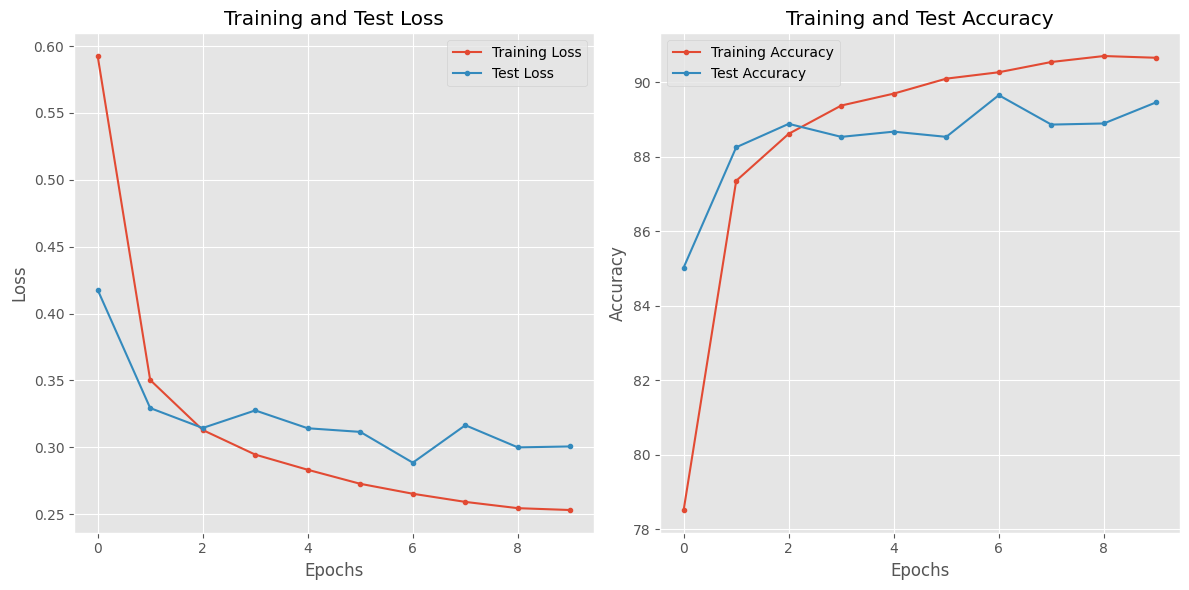

In [21]:
# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

###  **15. Make and evaluate random predictions**

In [22]:
def make_predictions(model=torch.nn.Module,
                     data=list,
                     device: torch.device=device):
    pred_probs = []
    model.to(device)

    model.eval()
    # Turn off gradient computation
    with torch.inference_mode():
        # Process each sample individually
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            # matplotlib dose'nt works with GPU
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [23]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [24]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9): # K ~ number of items you want to randomly select from a sequence.
    test_samples.append(sample)
    test_labels.append(label)

# view the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

**Visualization**

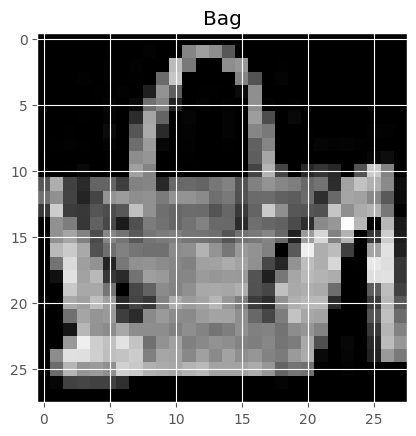

In [25]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])
plt.show()

In [26]:
# Make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# View first two prediction probabilities
print(pred_probs[:2])
print(test_labels)

tensor([[2.0421e-05, 1.5927e-08, 8.2963e-05, 7.4644e-07, 5.1572e-04, 5.9013e-06,
         6.9413e-05, 1.6480e-04, 9.9902e-01, 1.1755e-04],
        [1.9782e-10, 5.7638e-15, 4.8728e-11, 9.2627e-15, 1.8438e-13, 1.0000e+00,
         4.3491e-10, 3.2905e-11, 2.7373e-09, 2.4066e-09]])
[8, 5, 5, 8, 2, 8, 7, 9, 6]


In [27]:
# Convert prediction probabilities to labels
pred_classes = torch.argmax(pred_probs, dim=1)
pred_classes

tensor([8, 5, 5, 8, 2, 8, 7, 9, 0])

### **16. Visualizing the predictions**

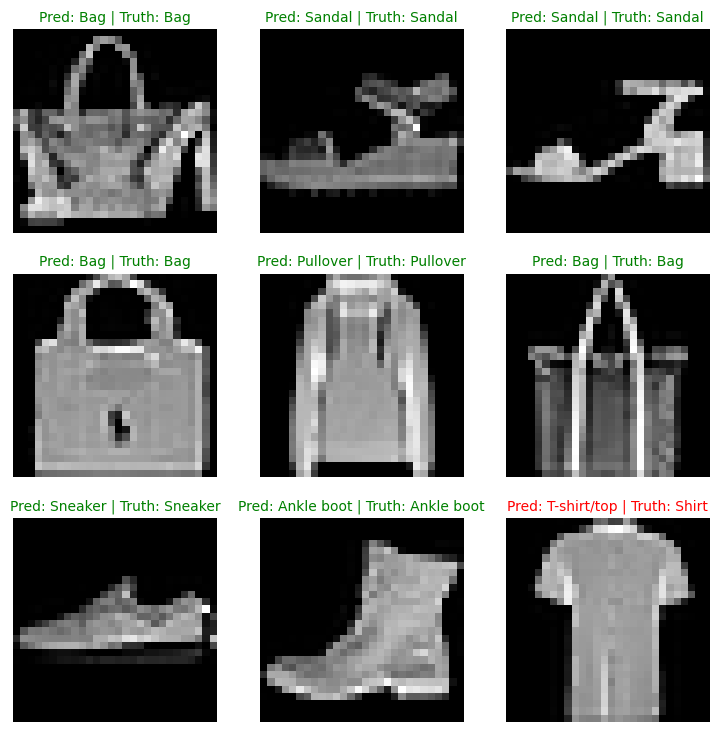

In [28]:
# Plot predictions
plt.figure(figsize=(9, 9))

n_rows = 3
n_cols = 3

for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(n_rows, n_cols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
      plt.title(title_text, fontsize=10, c="r")

    plt.axis(False);

### **17. Confusion matrix for further prediction evaluation**

Evaluating the classificaiton model visually.

**Steps:**
- Make predictions with our trained model on the test dataset.
- Make a confusion Matrix `torchmetrics.ConfusionMatrix`.
- Plot the confusion Matrix using `mlxtend.plotting.plot_confusion_matrix()`.


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

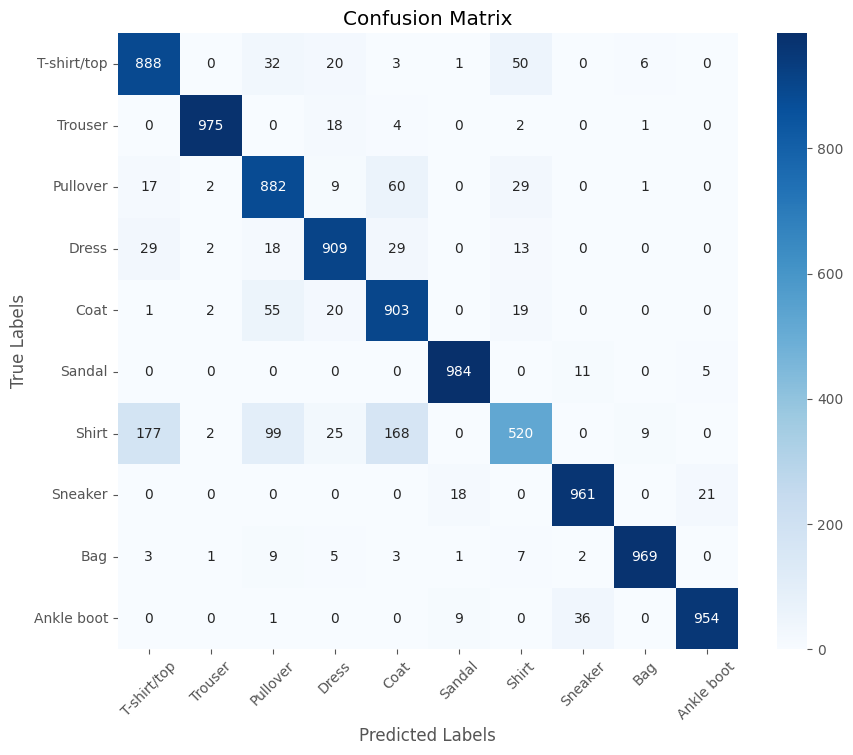

In [29]:
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize empty lists for true labels and predicted labels
true_labels = []
predicted_labels = []

model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Predictions..."):
        # Send the data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass - logits -> prediction probabilities -> prediction labels
        y_logit = model(X).squeeze()
        y_pred_prob = torch.softmax(y_logit, dim=1)
        y_pred = torch.argmax(y_pred_prob, dim=1)

        # Append true labels and predicted labels
        ## ü   # matplotlib likes working with numpy
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(y_pred.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues') # fmt ~ `d ~ decimal`, `.2f~ float with two decimal`

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=0, va='center')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

- `np.arange(len(class_names))+0.5` is used to put the tick to the center of the box.

### **18. Save and load the model**

#### **1. Save Model**

In [30]:
import torch
import os


# Create the directory
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Define the model's save path and name
moddel = "cnn_model.pth"
model_save_path = os.path.join(model_dir, model_dir)

# Save the model's state dictionary
print(f"Saving model to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

Saving model to: models/models


**Here’s why `model.state_dict()` is crucial:**

- **Modularity:** It allows for the easy saving, updating, altering, and restoring of model parameters, which adds a great deal of flexibility and modularity to PyTorch models and optimizers.

- **Checkpointing:** It is used for saving or loading models, which is particularly useful when you need to continue training from a specific point or want to share the model with others.

- **Transfer Learning:** When you want to use the model parameters as a starting point for training on a new task (transfer learning), `model.state_dict()` makes it easy to load the pre-trained parameters.

Alternate way
```python

from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)
```

#### **2. Load Model**

In [31]:
loaded_model = FashionMNISTModel(input_shape = 1,
                               hidden_units = 10,
                               output_shape = len(class_names))

loaded_model.load_state_dict(torch.load(f=model_save_path))
loaded_model.to(device)

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

#### **3. Evaluate loaded model**

In [32]:
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3006758391857147,
 'model_acc': 89.45686900958466}

In [33]:
loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3006758391857147,
 'model_acc': 89.45686900958466}

#### **4. Check Model Results**

In [34]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_results["model_loss"]),
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-02)

tensor(True)